sfsdfsdおれ

In [25]:
%pip install pandas
%pip install tqdm
%pip install re
%pip install sklearn
%pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
     

In [26]:
import pandas as pd

# データAとデータBのCSVファイルのパス
data_a_path = '../data/original_data/race_table/combined.csv'  # データAのCSVファイルパス
data_b_path = '../data/merged_data/merged_sorted.csv'  # データBのCSVファイルパス

# CSVファイルからデータを読み込む
data_a = pd.read_csv(data_a_path,low_memory=False)
data_b = pd.read_csv(data_b_path)
data_a=data_a.dropna()
data_b=data_b.dropna()
data_a=data_a.drop(columns=['first_horses', 'second_horses', 'third_horses', 'Time', 'Jockey', 'Trainer'])
# Code列でデータを結合 (data_bにdata_aの情報を追加)
merged_data = pd.merge(data_b, data_a, on='Code', how='left')

#結果の確認
merged_data.to_csv('../notebook/data-shin/merged_data_final.csv', index=False)
for i in merged_data.columns:
    # 各列のユニークな値とその出現回数を取得
    value_counts = df[i].value_counts()  # 各値とそのカウント
    print(f"{i}: {value_counts}")


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

特徴量の析出

In [9]:
import pandas as pd
import re
from tqdm import tqdm

file_path = '../notebook/data-shin/merged_data_final.csv'
# CSVファイルの読み込み
df = pd.read_csv(file_path)
# 12桁のコードのみを抽出
df = df[df['Code'].astype(str).str.match(r'^\d{12}$')]

# 正規表現の事前コンパイル（前後にある任意の空白を無視）
time_pattern1 = re.compile(r'\s*(\d+):(\d+\.\d+)\s*')
time_pattern2 = re.compile(r'\s*(\d+):(\d+):(\d+)\s*')
sex_age_pattern = re.compile(r'\s*([牡牝セ])(\d+)\s*')
distance_pattern = re.compile(r'\s*([ダ芝障])(\d+)\s*')
condition_pattern = re.compile(r'\s*([良重稍不])\s*')
weather_pattern = re.compile(r'\s*(晴|曇|小雨|雨|雪|小雪)\s*')
kinryou_pattern = re.compile(r'(\d+)\(([\+\-]?\d+)\)')


# 時間を秒に変換する関数 (ベクトル化)
def time_to_seconds(time_series):
    result = []
    for time_str in time_series:
        if isinstance(time_str, str):
            match1 = time_pattern1.match(time_str)
            if match1:
                minutes, seconds = int(match1.group(1)), float(match1.group(2))
                result.append(minutes * 60 + seconds)
                continue
            match2 = time_pattern2.match(time_str)
            if match2:
                minutes, seconds = int(match2.group(1)), float(match2.group(2))
                result.append(minutes * 60 + seconds)
                continue
        result.append(None)
    return result


# 性別と年齢を抽出する関数（ベクトル化）
def extract_sex_age_column(sex_age_series):
    sexes, ages = [], []
    for text in sex_age_series:
        match = sex_age_pattern.match(text) if isinstance(text, str) else None
        if match:
            sex = match.group(1)
            if sex in ['牡', '牝', 'セ']:  # 性別が牡、牝、セのみを許可
                sexes.append(sex)
                ages.append(int(match.group(2)))
            else:
                sexes.append(None)
                ages.append(None)
        else:
            sexes.append(None)
            ages.append(None)
    return pd.DataFrame({'Sex': sexes, 'Age': ages})


# 距離を抽出する関数（ベクトル化）
def extract_distance_column(distance_series):
    statuses, distances = [], []
    for text in distance_series:
        match = distance_pattern.match(text) if isinstance(text, str) else None
        if match:
            statuses.append(match.group(1))
            distances.append(int(match.group(2)))
        else:
            statuses.append(None)
            distances.append(None)
    return pd.DataFrame({'Sta': statuses, 'Dis': distances})


# 条件を抽出する関数（ベクトル化）
def extract_condition_column(condition_series):
    conditions = []
    
    for text in condition_series:
        match = condition_pattern.match(text) if isinstance(text, str) else None
        if match:
            conditions.append(match.group(1))
        else:
            conditions.append(None)
    return pd.Series(conditions)


# 天気を抽出する関数（ベクトル化）
def extract_weather_column(weather_series):
    weathers = []
    for text in weather_series:
        match = weather_pattern.match(text) if isinstance(text, str) else None
        if match:
            weathers.append(match.group(1))
        else:
            weathers.append(None)
    return pd.Series(weathers)


# 体重の変化を抽出する関数
def extract_weight_change(weight_series):
    weights, changes = [], []
    for text in weight_series:
        match = re.match(r'(\d+)\(([\+\-]?\d+)\)', text) if isinstance(text, str) else None
        if match:
            weights.append(int(match.group(1)))  # 体重
            changes.append(int(match.group(2)))  # 変化量
        else:
            weights.append(None)
            changes.append(None)
    return pd.DataFrame({'Weight': weights, 'Change': changes})

df['Time'] = time_to_seconds(df['Time'].values)

# SexとAgeの列に分割して格納
sex_age_df = extract_sex_age_column(df['Sex/Age'].values)
df[['Sex', 'Age']] = sex_age_df

# StaとDisの列に分割して格納
distance_df = extract_distance_column(df['Distance'].values)
df[['Sta', 'Dis']] = distance_df

# Conditionの列に分割して格納
df['Condition'] = extract_condition_column(df['Condition'].values)

# Weatherの列に分割して格納
df['Weather'] = extract_weather_column(df['Weather'].values)
# 新しいカラム 'Horse Weight' を追加して処理
weight_change_df = extract_weight_change(df['Horse Weight'].values)
df[['Weight', 'Change']] = weight_change_df

# NaN 値が含まれている行をフィルタリング
df = df.dropna(subset=['Sex', 'Age', 'Sta', 'Dis', 'Condition', 'Weather'])

# 不要な列を削除
df = df.drop('Sex/Age', axis=1)
df = df.drop('Distance', axis=1)
df=df.drop('Horse Weight',axis=1)
# フィルタリングしたデータをCSVに保存
df.to_csv('../notebook/data-shin/filtered_data.csv', index=False)

/tmp/ipykernel_1125/1133966646.py:7: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
import pandas as pd
import numpy as np

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv')

# 必要なカテゴリ変数の数値化
# 方法1: 文字列カテゴリを整数に変換
df['Horse Name'] = pd.factorize(df['Horse Name'])[0]
df['Jockey'] = pd.factorize(df['Jockey'])[0]
df['Trainer'] = pd.factorize(df['Trainer'])[0]
df['Banushi'] = pd.factorize(df['Banushi'])[0]
df['Track'] = pd.factorize(df['Track'])[0]
df['Weather'] = pd.factorize(df['Weather'])[0]
df['Sex'] = pd.factorize(df['Sex'])[0]

# 方法2: 日付データをカテゴリ型に変換する例
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())  # 日付を数値化（連続した数値）

#Codeカラムを消す
df=df.drop('Code',axis=1)
df=df.drop('Horse Number',axis=1)

# Weight列の処理 - '5(降)'のような文字列から数値のみを抽出
df['Weight'] = df['Weight'].apply(lambda x: float(str(x).split('(')[0]) if pd.notnull(x) else np.nan)
df['Change'] = df['Change'].apply(lambda x: float(x) if pd.notnull(x) else np.nan)

# 数値型の列のみを選択して相関係数行列を計算
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
print(corr_matrix)
# 相関係数の絶対値を取得し、上位10ペアを抽出（対角要素を除く）
corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_pairs.append({
            'pair': (numeric_cols[i], numeric_cols[j]),
            'correlation': abs(corr_matrix.iloc[i,j])
        })

# 相関係数の絶対値で降順ソート
corr_pairs = sorted(corr_pairs, key=lambda x: x['correlation'], reverse=True)

# 上位10ペアを表示
print("Top 10 correlated pairs:")
for i, pair in enumerate(corr_pairs[:10], 1):
    print(f"{i}. {pair['pair'][0]} - {pair['pair'][1]}: {pair['correlation']:.3f}")


/tmp/ipykernel_40468/1983141988.py:5: DtypeWarning: Columns (1,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../notebook/data-shin/filtered_data.csv')


             Frame Rank  Horse Name   Kinryou    Jockey      Time    Nobori  \
Frame Rank     1.000000   -0.011883 -0.000154 -0.005887  0.000284  0.019357   
Horse Name    -0.011883    1.000000 -0.132046  0.619328  0.075380 -0.067430   
Kinryou       -0.000154   -0.132046  1.000000 -0.078536  0.309331 -0.310887   
Jockey        -0.005887    0.619328 -0.078536  1.000000  0.061148 -0.035005   
Time           0.000284    0.075380  0.309331  0.061148  1.000000 -0.360421   
Nobori         0.019357   -0.067430 -0.310887 -0.035005 -0.360421  1.000000   
Ninki          0.001498    0.052998 -0.061918  0.074946  0.024220 -0.045414   
Trainer       -0.003077    0.618055 -0.102605  0.525383  0.059373 -0.051512   
Banushi       -0.004301    0.593453 -0.110018  0.447008  0.022206  0.019182   
Date           0.012155   -0.943088  0.134428 -0.673825 -0.082432  0.069828   
Track         -0.023983    0.305238  0.038204  0.229157  0.133146 -0.286749   
Weather       -0.002136   -0.011594 -0.009573 -0.017

相関係数行列

one-hoting

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted

# データの読み込み
try:
    df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False, nrows=70000)
except Exception as e:
    print(f"Error while reading the data: {e}")

# 必要なカテゴリ変数にOne-Hotエンコーディングを適用
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
try:
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
except Exception as e:
    print(f"Error while applying One-Hot Encoding: {e}")

# 日付データを数値化
try:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].map(lambda date: date.toordinal())
except Exception as e:
    print(f"Error while converting date to ordinal: {e}")

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

try:
    df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)
except Exception as e:
    print(f"Error while processing Weight column: {e}")

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

try:
    df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)
except Exception as e:
    print(f"Error while processing Change column: {e}")

# 欠損値を含む行を削除（補完方法も検討）
try:
    df = df.dropna()  # もしデータが不足している場合、欠損値の補完も考慮する
except Exception as e:
    print(f"Error while dropping rows with missing values: {e}")

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code', 'Horse Number'])

# 確保するために、説明変数はすべて数値型に
try:
    features = features.select_dtypes(include=[np.number])
except Exception as e:
    print(f"Error while selecting numeric features: {e}")

# データを訓練データとテストデータに分割
try:
    X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)
except Exception as e:
    print(f"Error while splitting the data into training and testing sets: {e}")

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    model.fit(X_train, y_train)
    check_is_fitted(model)
    # テストデータに対する予測
    y_pred = model.predict(X_test)
    # 予測結果と実際のタイムの差を計算
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    # 予測タイムと実際のタイムを表示
    comparison_df = pd.DataFrame({'Actual Time': y_test, 'Predicted Time': y_pred})
    
    print(comparison_df.head(10))
    print(comparison_df.tail(10))
except (ValueError, AttributeError) as e:
    print(f"Error during model fitting or prediction: {e}")



Mean Squared Error: 1.5553754562406237
Mean Absolute Error: 0.9086452096877902
R2 Score: 0.9962767496176523
       Actual Time  Predicted Time
14558         75.5          74.344
47286         85.0          84.635
28091         89.7          90.865
29606         76.0          75.735
54587         91.9          91.940
44941        112.6         109.795
58314         82.2          82.617
34716        112.6         111.997
39026        104.2         104.913
13444        120.8         120.623
       Actual Time  Predicted Time
5755         118.4         118.585
22825         93.0          92.837
11186         88.5          88.651
31937        107.6         106.935
68286         73.8          73.315
52256         81.0          81.832
14015         96.0          95.076
60488         94.9          96.594
3622          92.1          92.799
19656         69.9          69.921


機械学習でタイム予測(500000行)(ランダムフォレスト)


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False, nrows=500000)

# 必要なカテゴリ変数の数値化
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# 日付データを数値化
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)

# 欠損値を含む行を削除
df = df.dropna()

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code','Horse Number'])

# 确保所有的特征列都是数值型
features = features.select_dtypes(include=[np.number])

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    model.fit(X_train, y_train)
    check_is_fitted(model)
    # テストデータに対する予測
    y_pred = model.predict(X_test)
    # 予測結果と実際のタイムの差を計算
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    # 予測タイムと実際のタイムを表示
    comparison_df = pd.DataFrame({'Actual Time': y_test, 'Predicted Time': y_pred})
    
    
    print(comparison_df.head(10))
    print(comparison_df.tail(10))
except (ValueError, AttributeError) as e:
    print(f"Error during model fitting or prediction: {e}")

Mean Squared Error: 0.9647742792619719
Mean Absolute Error: 0.7408475315683096
R2 Score: 0.9975617383110674
        Actual Time  Predicted Time
440484         93.2          92.290
170130         75.4          76.226
84159          75.8          75.233
272923         84.3          85.704
195556         88.7          88.479
265601         98.1          97.176
63784          99.1          99.643
485157        103.8         105.160
385200         69.0          69.347
14127          78.2          77.399
        Actual Time  Predicted Time
58116          93.8          93.299
186338         93.5          94.570
257155         91.3          91.065
336424         92.4          93.133
30412         114.3         113.148
116819        116.2         116.077
459483         93.5          92.921
432530         85.7          87.369
299024         78.5          79.309
158697         77.5          77.423


GPU加速on

In [6]:
%pip install tensorflow-gpu
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 124, in _parse_requirement_details
          marker = _p

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False, nrows=500000)

# 必要なカテゴリ変数の数値化
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# 日付データを数値化
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)

# 欠損値を含む行を削除
df = df.dropna()

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code','Horse Number'])
features = features.select_dtypes(include=[np.number])

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    # モデルの訓練
    model.fit(X_train, y_train)
    check_is_fitted(model)

    # テストデータに対する予測
    y_pred = model.predict(X_test)

    # 評価指標の計算
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R² Score: {r2}")

    # クロスバリデーションの実施（MAEを評価）
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-Validation MAE: {-np.mean(cv_scores)}")

    # 実際のタイムと予測タイムの比較
    comparison_df = pd.DataFrame({'Actual Time': y_test, 'Predicted Time': y_pred})
    print(comparison_df.head(10))
    print(comparison_df.tail(10))

    # 実際のタイムと予測タイムの散布図
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Time")
    plt.ylabel("Predicted Time")
    plt.title("Actual vs Predicted Time")
    plt.show()

    # 残差の分布をヒストグラムで可視化
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Distribution of Residuals")
    plt.show()

except (ValueError, AttributeError) as e:
    print(f"Error during model fitting or prediction: {e}")


In [2]:
%pip tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


tensorflow動作確認

In [3]:
import tensorflow as tf
print(tf.__version__)


2024-11-18 18:49:20.952360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 18:49:21.061877: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 18:49:21.159098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731923361.290143    4946 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731923361.326640    4946 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 18:49:21.560855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2.18.0


tensorflowで機械学習 モデルの保存

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re
import tqdm
file_path = '../notebook/data-shin/merged_data_final.csv'
# CSVファイルの読み込み
df = pd.read_csv(file_path)
# 12桁のコードのみを抽出
df = df[df['Code'].astype(str).str.match(r'^\d{12}$')]

# 正規表現の事前コンパイル（前後にある任意の空白を無視）
time_pattern1 = re.compile(r'\s*(\d+):(\d+\.\d+)\s*')
time_pattern2 = re.compile(r'\s*(\d+):(\d+):(\d+)\s*')
sex_age_pattern = re.compile(r'\s*([牡牝セ])(\d+)\s*')
distance_pattern = re.compile(r'\s*([ダ芝障])(\d+)\s*')
condition_pattern = re.compile(r'\s*([良重稍不])\s*')
weather_pattern = re.compile(r'\s*(晴|曇|小雨|雨|雪|小雪)\s*')
kinryou_pattern = re.compile(r'(\d+)\(([\+\-]?\d+)\)')


# 時間を秒に変換する関数 (ベクトル化)
def time_to_seconds(time_series):
    result = []
    for time_str in time_series:
        if isinstance(time_str, str):
            match1 = time_pattern1.match(time_str)
            if match1:
                minutes, seconds = int(match1.group(1)), float(match1.group(2))
                result.append(minutes * 60 + seconds)
                continue
            match2 = time_pattern2.match(time_str)
            if match2:
                minutes, seconds = int(match2.group(1)), float(match2.group(2))
                result.append(minutes * 60 + seconds)
                continue
        result.append(None)
    return result


# 性別と年齢を抽出する関数（ベクトル化）
def extract_sex_age_column(sex_age_series):
    sexes, ages = [], []
    for text in sex_age_series:
        match = sex_age_pattern.match(text) if isinstance(text, str) else None
        if match:
            sex = match.group(1)
            if sex in ['牡', '牝', 'セ']:  # 性別が牡、牝、セのみを許可
                sexes.append(sex)
                ages.append(int(match.group(2)))
            else:
                sexes.append(None)
                ages.append(None)
        else:
            sexes.append(None)
            ages.append(None)
    return pd.DataFrame({'Sex': sexes, 'Age': ages})


# 距離を抽出する関数（ベクトル化）
def extract_distance_column(distance_series):
    statuses, distances = [], []
    for text in distance_series:
        match = distance_pattern.match(text) if isinstance(text, str) else None
        if match:
            statuses.append(match.group(1))
            distances.append(int(match.group(2)))
        else:
            statuses.append(None)
            distances.append(None)
    return pd.DataFrame({'Sta': statuses, 'Dis': distances})


# 条件を抽出する関数（ベクトル化）
def extract_condition_column(condition_series):
    conditions = []
    
    for text in condition_series:
        match = condition_pattern.match(text) if isinstance(text, str) else None
        if match:
            conditions.append(match.group(1))
        else:
            conditions.append(None)
    return pd.Series(conditions)


# 天気を抽出する関数（ベクトル化）
def extract_weather_column(weather_series):
    weathers = []
    for text in weather_series:
        match = weather_pattern.match(text) if isinstance(text, str) else None
        if match:
            weathers.append(match.group(1))
        else:
            weathers.append(None)
    return pd.Series(weathers)


# 体重の変化を抽出する関数
def extract_weight_change(weight_series):
    weights, changes = [], []
    for text in weight_series:
        match = re.match(r'(\d+)\(([\+\-]?\d+)\)', text) if isinstance(text, str) else None
        if match:
            weights.append(int(match.group(1)))  # 体重
            changes.append(int(match.group(2)))  # 変化量
        else:
            weights.append(None)
            changes.append(None)
    return pd.DataFrame({'Weight': weights, 'Change': changes})



df['Time'] = time_to_seconds(df['Time'].values)

# SexとAgeの列に分割して格納
sex_age_df = extract_sex_age_column(df['Sex/Age'].values)
df[['Sex', 'Age']] = sex_age_df

# StaとDisの列に分割して格納
distance_df = extract_distance_column(df['Distance'].values)
df[['Sta', 'Dis']] = distance_df

# Conditionの列に分割して格納
df['Condition'] = extract_condition_column(df['Condition'].values)

# Weatherの列に分割して格納
df['Weather'] = extract_weather_column(df['Weather'].values)
# 新しいカラム 'Horse Weight' を追加して処理
weight_change_df = extract_weight_change(df['Horse Weight'].values)
df[['Weight', 'Change']] = weight_change_df

# NaN 値が含まれている行をフィルタリング
df = df.dropna(subset=['Sex', 'Age', 'Sta', 'Dis', 'Condition', 'Weather'])

# 不要な列を削除
df = df.drop('Sex/Age', axis=1)
df = df.drop('Distance', axis=1)
df=df.drop('Horse Weight',axis=1)

# 必要なカテゴリ変数の数値化
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# 日付データを数値化
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)

# 欠損値を含む行を削除
df = df.dropna()

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code','Horse Number'])

# 确保所有的特征列都是数値型
features = features.select_dtypes(include=[np.number])

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# モデルの定義
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの訓練
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# モデルの保存
model.save('trained_model.h5')

# テストデータに対する予測
y_pred = model.predict(X_test)

# 予測結果と実際のタイムの差を計算
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")
# 予測タイムと実際のタイムを表示
# 修正: y_predを1次元のnumpy配列に変換
y_pred_1d = y_pred.reshape(y_pred.shape[0])
# 速度の向上: numpyのconcatenate関数を使用
comparison_df = pd.DataFrame(np.concatenate((y_test.values.reshape(-1, 1), y_pred_1d.reshape(-1, 1)), axis=1), columns=['Actual Time', 'Predicted Time'])
    
print(comparison_df.head(10))
print(comparison_df.tail(10))


/tmp/ipykernel_2636/818953571.py:10: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Epoch 1/20


/home/ximihu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33572/33572 ━━━━━━━━━━━━━━━━━━━━ 33s 961us/step - loss: 63241136.0000 - val_loss: 80190.7578
Epoch 2/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 32s 963us/step - loss: 30030.9277 - val_loss: 8704.3730
Epoch 3/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 32s 964us/step - loss: 1263.7177 - val_loss: 120.5587
Epoch 4/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 33s 970us/step - loss: 90.7938 - val_loss: 28.0929
Epoch 5/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 33s 973us/step - loss: 24.2224 - val_loss: 33.2676
Epoch 6/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 33s 972us/step - loss: 17.4873 - val_loss: 13.0512
Epoch 7/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 33s 981us/step - loss: 16.1255 - val_loss: 11.9093
Epoch 8/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 15.3413 - val_loss: 12.5375
Epoch 9/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 14.2409 - val_loss: 29.4864
Epoch 10/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 14.6003 - val_loss: 18.7091
Epoch 11/20
33572/33572 ━━━━━━━━━━━━━━━━━━━━ 37s 

8393/8393 ━━━━━━━━━━━━━━━━━━━━ 6s 692us/step
Mean Squared Error: 8.78554590614421
Mean Absolute Error: 2.2518303626471488
R2 Score: 0.9804887046941517
   Actual Time  Predicted Time
0         99.2       97.713959
1        122.8      123.613907
2        107.7      105.159180
3         94.0       91.678055
4         90.2       89.062775
5         93.2       91.141563
6         74.6       74.598030
7        145.6      153.934418
8         89.7       88.289574
9         87.0       84.652481
        Actual Time  Predicted Time
268561         88.9       85.875458
268562         61.9       60.985794
268563         79.1       78.088165
268564         54.9       60.630394
268565         99.0       97.765419
268566         97.3       96.167770
268567         71.4       73.363899
268568        106.5      107.540054
268569         89.2       85.317955
268570         91.9       90.096123


モデルで予測(未完成)

In [19]:
# モデルの読み込み
import tensorflow as tf
import pandas as pd
import numpy as np
file_path = '../notebook/data-shin/test_data.csv'
# CSVファイルの読み込み
df = pd.read_csv(file_path)
loaded_model = tf.keras.models.load_model('trained_model.h5')

# 特徴量の準備
df_for_prediction = df.drop(['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Shoukin', 'Date', 'Track', 'Race Number'], axis=1)

# 数値変換（欠損値処理も追加）
df_for_prediction = df_for_prediction.applymap(lambda x: pd.to_numeric(x, errors='coerce') if isinstance(x, str) else x)
df_for_prediction.fillna(0, inplace=True)  # 欠損値を 0 で埋める（必要に応じて変更）

# NumPy 配列に変換
df_numpy = df_for_prediction.to_numpy().astype(np.float32)

# 予測
# モデルの入力形状に合わせて NumPy 配列を調整
df_numpy_adjusted = df_numpy.reshape(df_numpy.shape[0], -1)
y_pred = loaded_model.predict(df_numpy_adjusted)

# 予測結果を DataFrame に追加
df_for_prediction['Predicted Time'] = y_pred.reshape(y_pred.shape[0])

# 結果の表示
print(df_for_prediction.head())


/tmp/ipykernel_2636/1498754073.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_for_prediction = df_for_prediction.applymap(lambda x: pd.to_numeric(x, errors='coerce') if isinstance(x, str) else x)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 17, but received input with shape (4, 15)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(4, 15), dtype=float32)
  • training=False
  • mask=None

馬ごとの距離ごとの確率分布

ターミナルで以下のコードの実行でフォントをインストール


sudo apt update
sudo apt install fonts-noto-cjk fonts-noto-cjk-extra

findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

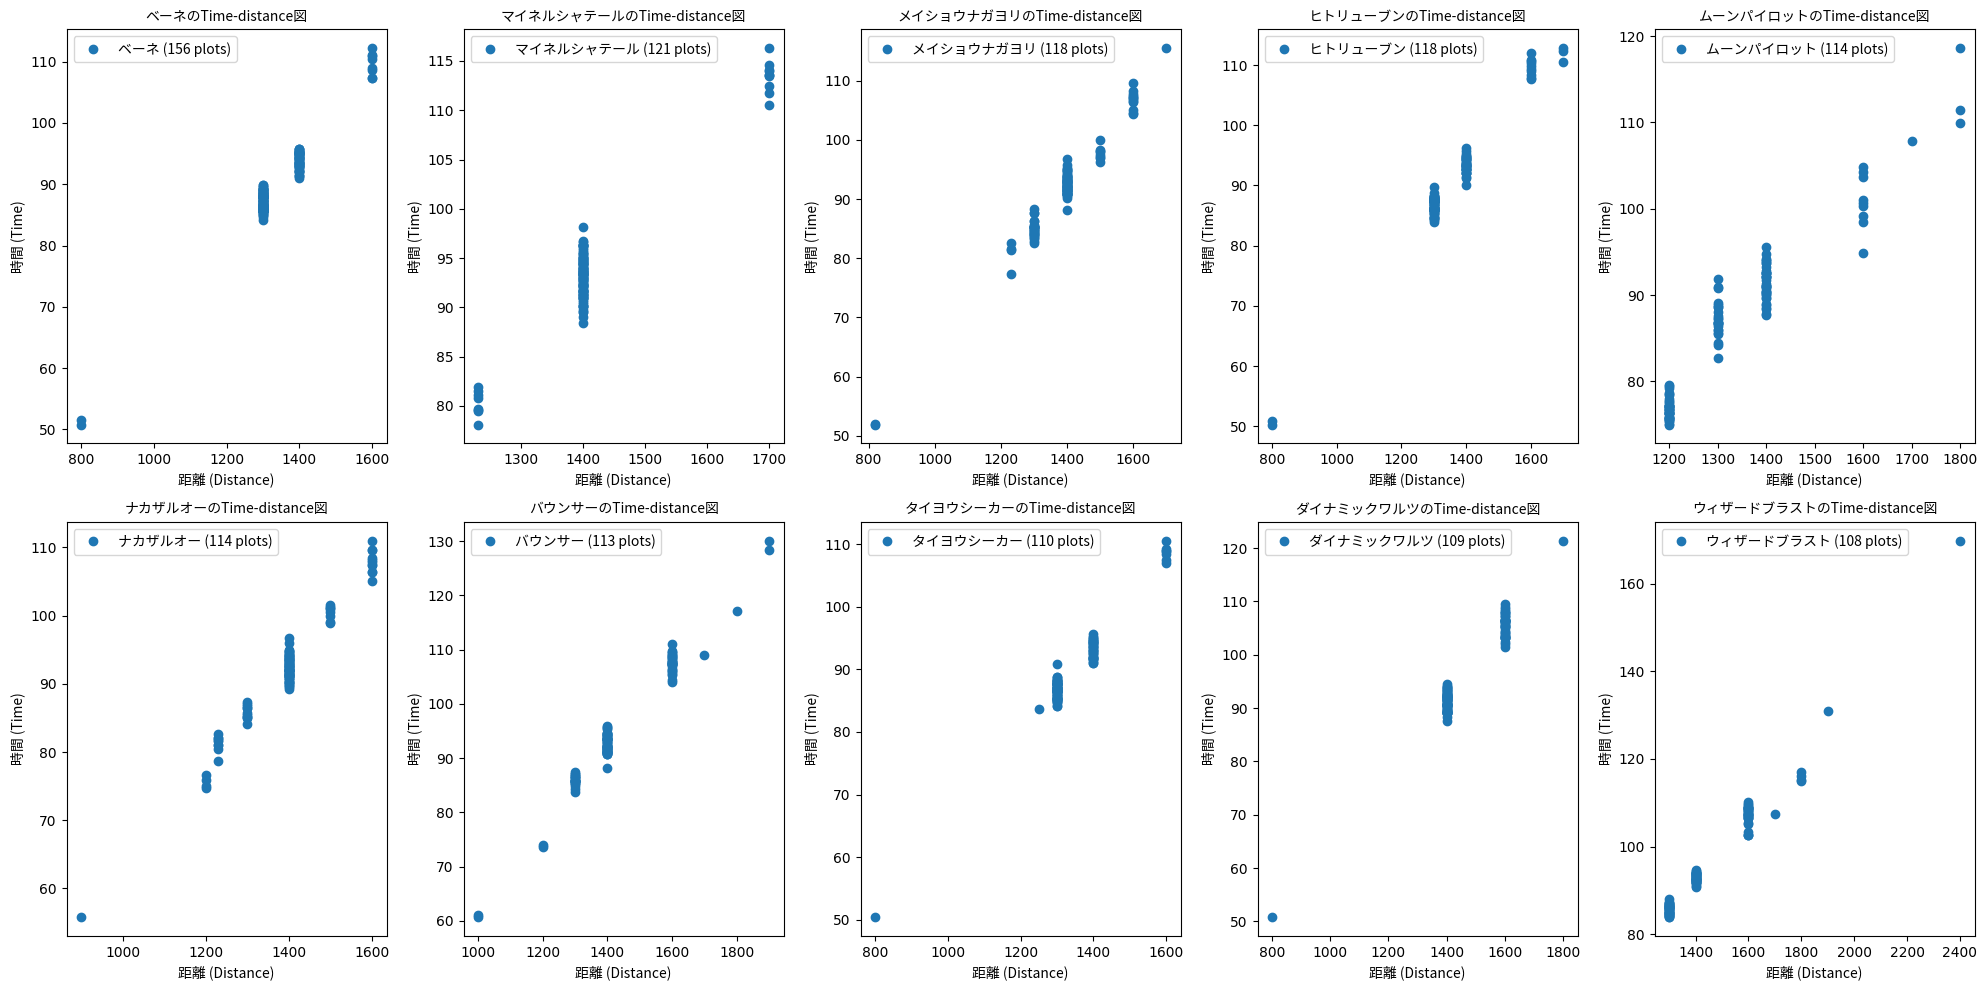

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

# フォント設定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 適切なフォントパスを指定
font_prop = font_manager.FontProperties(fname=font_path)

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False)

# 必要なカテゴリ変数の数値化
df['Jockey'] = pd.factorize(df['Jockey'])[0]
df['Trainer'] = pd.factorize(df['Trainer'])[0]
df['Banushi'] = pd.factorize(df['Banushi'])[0]
df['Track'] = pd.factorize(df['Track'])[0]
df['Weather'] = pd.factorize(df['Weather'])[0]
df['Sex'] = pd.factorize(df['Sex'])[0]

# 日付データをカテゴリ型に変換
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# 不要なカラムを削除
df = df.drop(['Code', 'Horse Number'], axis=1)

# Weight列の処理
df['Weight'] = df['Weight'].apply(lambda x: float(str(x).split('(')[0]) if pd.notnull(x) else np.nan)
df['Change'] = df['Change'].apply(lambda x: float(x) if pd.notnull(x) else np.nan)

# 出現頻度上位10の馬のTime-distance図を作成
top_10_horses = df['Horse Name'].value_counts().nlargest(10).index
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, horse in enumerate(top_10_horses):
    horse_data = df[df['Horse Name'] == horse]
    ax = axs[i // 5, i % 5]
    ax.plot(horse_data['Dis'], horse_data['Time'], 'o', label=f'{horse} ({len(horse_data)} plots)')
    ax.set_xlabel('距離 (Distance)', fontproperties=font_prop)
    ax.set_ylabel('時間 (Time)', fontproperties=font_prop)
    ax.set_title(f'{horse}のTime-distance図', fontproperties=font_prop)
    ax.legend(prop=font_prop)
plt.tight_layout()
plt.show()


確率密度関数の近似及び導出(未完成)

findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

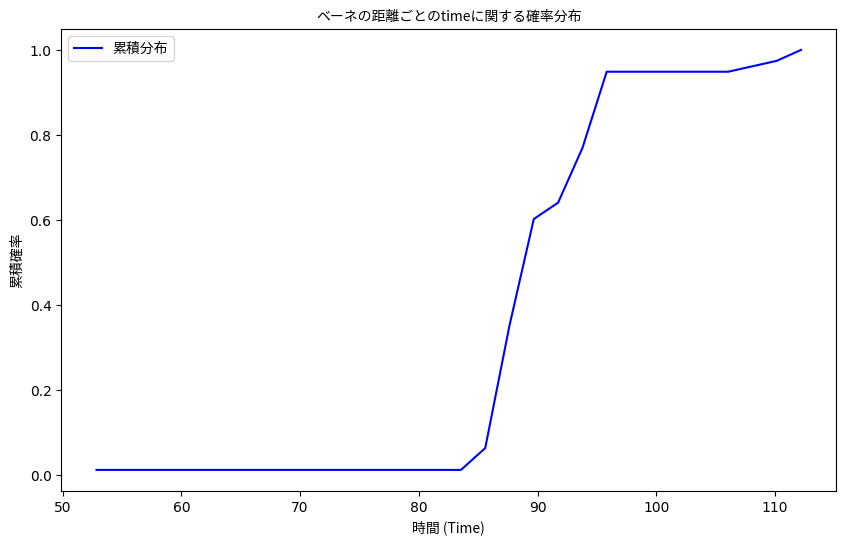

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import gaussian_kde

# フォント設定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 適切なフォントパスを指定
font_prop = font_manager.FontProperties(fname=font_path)

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False)

# 必要なカテゴリ変数の数値化
df['Jockey'] = pd.factorize(df['Jockey'])[0]
df['Trainer'] = pd.factorize(df['Trainer'])[0]
df['Banushi'] = pd.factorize(df['Banushi'])[0]
df['Track'] = pd.factorize(df['Track'])[0]
df['Weather'] = pd.factorize(df['Weather'])[0]
df['Sex'] = pd.factorize(df['Sex'])[0]

# 日付データをカテゴリ型に変換
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# 不要なカラムを削除
df = df.drop(['Code', 'Horse Number'], axis=1)

# Weight列の処理
df['Weight'] = df['Weight'].apply(lambda x: float(str(x).split('(')[0]) if pd.notnull(x) else np.nan)
df['Change'] = df['Change'].apply(lambda x: float(x) if pd.notnull(x) else np.nan)

# 出現頻度1位の馬の距離ごとのtimeに関する確率分布を計算
top_horse = df['Horse Name'].value_counts().nlargest(1).index[0]
horse_data = df[df['Horse Name'] == top_horse]

# 距離ごとのtimeの確率密度関数を計算
density, bins = np.histogram(horse_data['Time'], bins=30, density=True)
cumulative_density = np.cumsum(density)
cumulative_density = cumulative_density / cumulative_density[-1]

# 確率分布のプロット
plt.figure(figsize=(10, 6))
plt.plot(bins[1:], cumulative_density, label='累積分布', color='blue')
plt.xlabel('時間 (Time)', fontproperties=font_prop)
plt.ylabel('累積確率', fontproperties=font_prop)
plt.title(f'{top_horse}の距離ごとのtimeに関する確率分布', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.show()


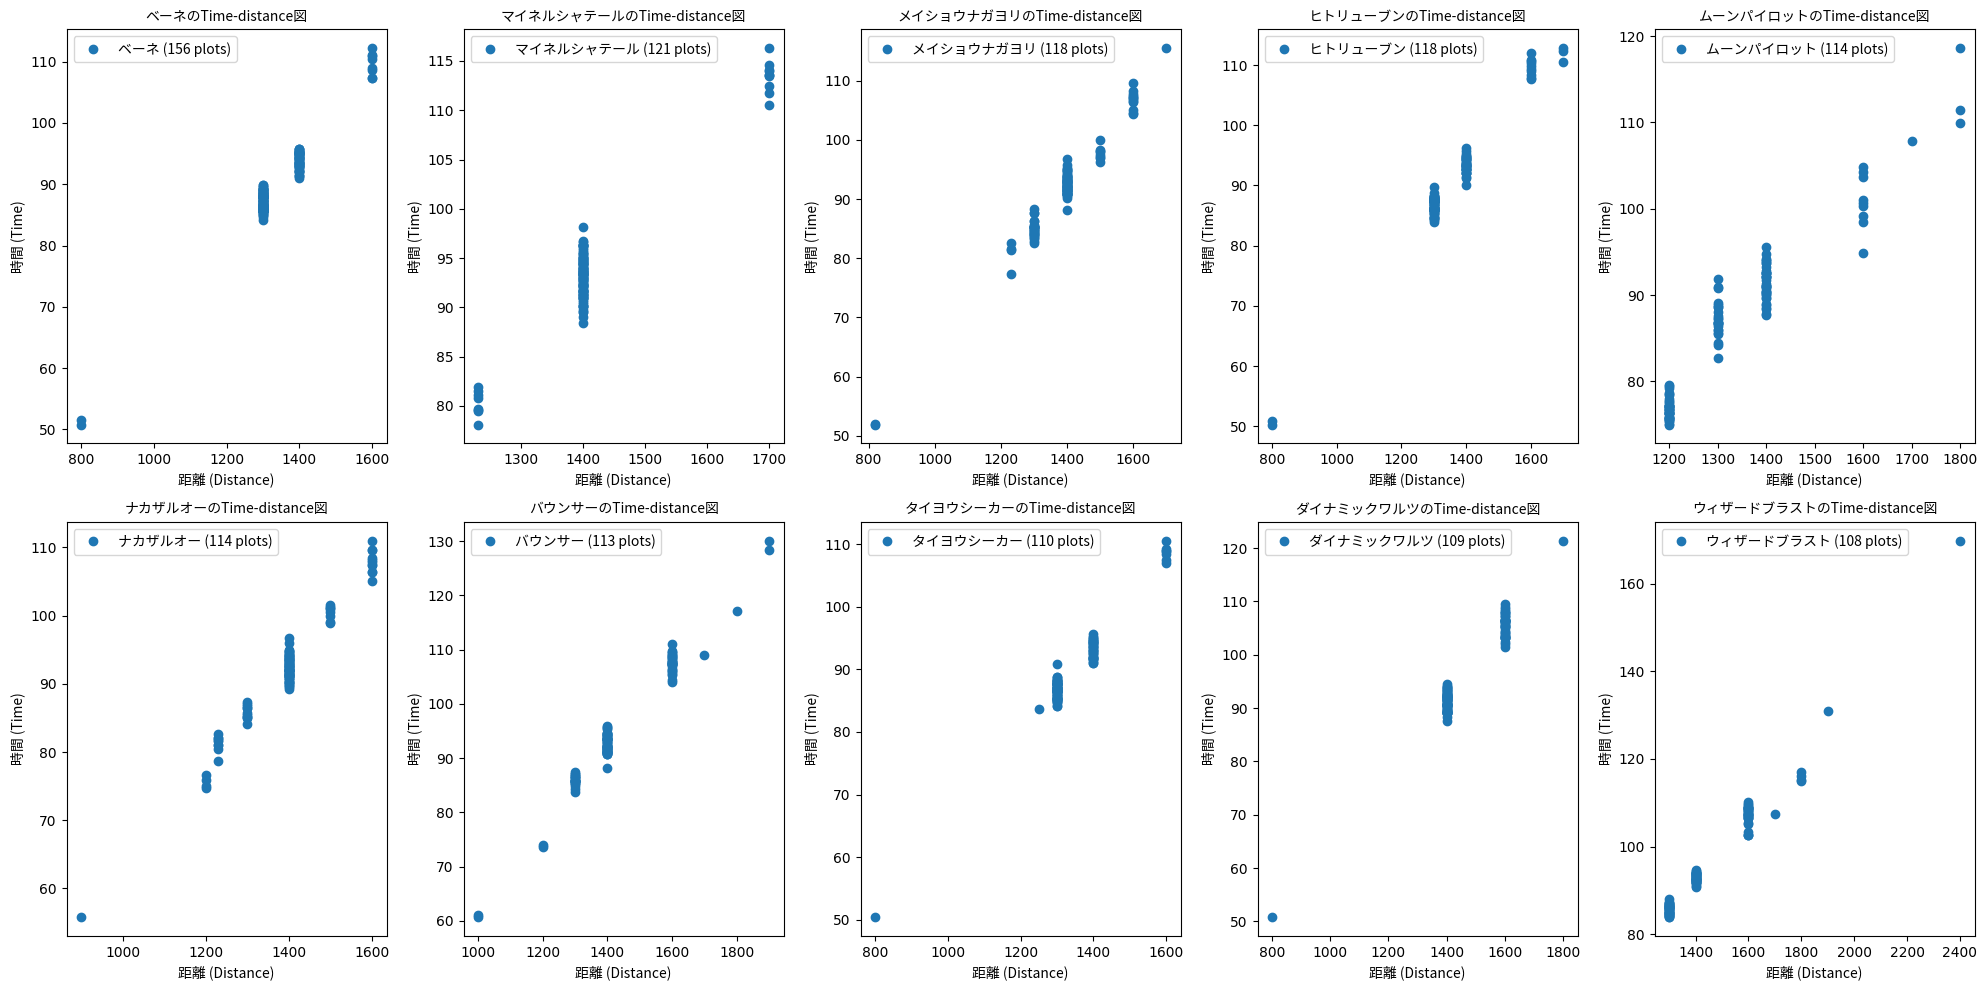

ベーネの確率密度関数: 1/(sqrt(2*pi)*7.103865329059401)*exp(-((x-90.10576923076923)^2)/(2*50.46490261341223))
尤度関数は6.5112619888814524e-37
マイネルシャテールの確率密度関数: 1/(sqrt(2*pi)*6.917684264029753)*exp(-((x-93.99504132231405)^2)/(2*47.85435557680487))
尤度関数は3.047884233296637e-78
メイショウナガヨリの確率密度関数: 1/(sqrt(2*pi)*8.633922261450865)*exp(-((x-91.66610169491526)^2)/(2*74.54461361677681))
尤度関数は4.6972946760164644e-104
ヒトリューブンの確率密度関数: 1/(sqrt(2*pi)*9.027668535986104)*exp(-((x-90.8135593220339)^2)/(2*81.49879919563348))
尤度関数は2.205037509019346e-127
ムーンパイロットの確率密度関数: 1/(sqrt(2*pi)*9.0901734138099)*exp(-((x-87.01228070175438)^2)/(2*82.63125269313633))
尤度関数は1.2288830823338945e-148
ナカザルオーの確率密度関数: 1/(sqrt(2*pi)*8.088573469754929)*exp(-((x-92.03947368421052)^2)/(2*65.42502077562328))
尤度関数は4.63675686916345e-178
バウンサーの確率密度関数: 1/(sqrt(2*pi)*10.811825566880563)*exp(-((x-95.50176991150441)^2)/(2*116.8955720886522))
尤度関数は1.9528230479422001e-196
タイヨウシーカーの確率密度関数: 1/(sqrt(2*pi)*6.943042239335009)*exp(-((x-89.86090909090906)^2)/(2*48

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import norm
import math

# フォント設定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 適切なフォントパスを指定
font_prop = font_manager.FontProperties(fname=font_path)

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False)

# 出現頻度上位10の馬のTime-distance図を作成
top_10_horses = df['Horse Name'].value_counts().nlargest(10).index
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, horse in enumerate(top_10_horses):
    horse_data = df[df['Horse Name'] == horse]
    ax = axs[i // 5, i % 5]
    ax.plot(horse_data['Dis'], horse_data['Time'], 'o', label=f'{horse} ({len(horse_data)} plots)')
    ax.set_xlabel('距離 (Distance)', fontproperties=font_prop)
    ax.set_ylabel('時間 (Time)', fontproperties=font_prop)
    ax.set_title(f'{horse}のTime-distance図', fontproperties=font_prop)
    ax.legend(prop=font_prop)
plt.tight_layout()
plt.show()

# 確率密度関数の掛け合わせの式（正規分布を仮定）
# 正規分布の式を掛け合わせるための変数を初期化
combined_pdf = 1

# xの値を指定する必要があるが、ここではxの値が指定されていないため、仮のxの値を設定
x = 0  # 仮のxの値を設定

for horse in top_10_horses:
    horse_data = df[df['Horse Name'] == horse]
    mean, std = norm.fit(horse_data['Time'])
    # 正規分布の式を掛け合わせる
    combined_pdf *= (1 / (math.sqrt(2 * math.pi) * std)) * math.exp(-((x - mean) ** 2) / (2 * std ** 2))
    print(f'{horse}の確率密度関数: 1/(sqrt(2*pi)*{std})*exp(-((x-{mean})^2)/(2*{std**2}))')  # 正規分布の式を出力
    print(f"尤度関数は{combined_pdf}")


format_dataで機械学習

In [24]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np

# CSVデータの読み込み
data = pd.read_csv("./format_data.csv")

# DataFrameの作成
df1 = pd.DataFrame(data)
df1 = df1[["Rank","Kinryou","Time","Nobori","Ninki","Race Number","Distance","Weight","Weight Change","Ground_ダ","Ground_芝","Ground_障","Condition_不","Condition_稍","Condition_良","Condition_重","Weather_小雨","Weather_小雪","Weather_晴","Weather_曇","Weather_雨","Weather_雪","Sex_セ","Sex_牝","Sex_牡","Age_Under4","Age_Above4"]]

# 特徴量とターゲット変数の定義
X = df1.drop('Time', axis=1)
y = df1['Time']

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_trainとX_testのデータ型をfloat64に変換
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)

# y_trainとy_testのデータ型をfloat64に変換
y_train = y_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
y_test = y_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)

# モデルの定義
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# モデルの訓練
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# モデルの保存
model.save('trained_model.keras')

/tmp/ipykernel_1136/719920590.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./format_data.csv")
/home/ximihu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 200.5233 - val_loss: 7.5599
Epoch 2/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 7.4936 - val_loss: 9.6425
Epoch 3/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 7.6961 - val_loss: 6.1652
Epoch 4/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 7.0436 - val_loss: 11.4801
Epoch 5/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.6826 - val_loss: 5.4247
Epoch 6/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.4944 - val_loss: 8.5461
Epoch 7/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.2279 - val_loss: 4.9430
Epoch 8/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.0108 - val_loss: 4.9822
Epoch 9/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.8368 - val_loss: 4.8951
Epoch 10/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.7763 - val_loss: 6.1149
Epoch 11/20
2103/2103 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.7755 - val_loss: 5.4250
Epoch 12/20
2103/2103 ━━━━━

mergedからformatまで

In [22]:
import pandas as pd

# CSVデータの読み込み
data = pd.read_csv("./data-shin/merged_data_final.csv")

# DataFrameの作成
df = pd.DataFrame(data)
# Horse Weightを変形
df[['Weight', 'Weight Change']] = df['Horse Weight'].str.extract(r'(\d+)\s*\(\s*([+-]?\d+)\s*\)')
df['Weight'] = df['Weight'].fillna(0)
df['Weight'] = df['Weight'].astype(int)
df['Weight Change'] = df['Weight Change'].fillna(0)
df['Weight Change'] = df['Weight Change'].astype(int)
df.drop(columns=['Horse Weight'], inplace=True)
# 「Sex/Age」列を「Sex」と「Age」に分ける
df['Sex'] = df['Sex/Age'].str[0] 
df = df[df['Sex'].str.contains('牝|牡|セ')]

df['Age'] = df['Sex/Age'].str[1].astype(int)
df['Age'] = pd.cut(df['Age'], bins=[0, 4, 100], labels=['Under4', 'Above4'])

df.drop(columns=['Sex/Age'], inplace=True)
# Distanceを分離
df['Ground'] = df['Distance'].str[0]
df['Distance'] = df['Distance'].str[1:]
# Ground, Condition, Weatherをダミー変数に変換
dummy = pd.get_dummies(df[['Ground', 'Condition', 'Weather','Sex','Age']])

# データフレームを結合し、要らないデータを破棄
df = pd.concat([df, dummy], axis=1)
df.drop(columns=['Ground', 'Condition', 'Weather','Sex','Age'], inplace=True)

# first_chars = df['Condition'].dropna().apply(lambda x: str(x)[0])  # NaNを除外し、先頭文字を取得
# unique_first_chars = first_chars.unique()  # ユニークな文字を取得

# # 結果を表示
# print("0インデックス目のユニークな文字:", list(unique_first_chars))
# Rankにある"(降)"を除去
df['Rank'] = df['Rank'].astype(str).str.replace(r'[()降]', '', regex = True)
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce').astype('Int64') # errors='coerce'でエラーをNaNに変換

df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce').astype('Float64') # errors='coerce'でエラーをNaNに変換
df1 = df[["Rank","Kinryou","Time","Nobori","Tansyou","Ninki","Shoukin","Race Number","Distance","Weight","Weight Change"]]
print('データ型の確認（型変換前）\n{}'.format(df1.dtypes))


/tmp/ipykernel_1136/466034722.py:4: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./data-shin/merged_data_final.csv")


データ型の確認（型変換前）
Rank               Int64
Kinryou          float64
Time              object
Nobori           float64
Tansyou           object
Ninki            float64
Shoukin           object
Race Number      float64
Distance         Float64
Weight             int64
Weight Change      int64
dtype: object
Epoch 1/100


/home/ximihu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8412/8412 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 14.8489 - val_loss: 2.2364
Epoch 2/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.1552 - val_loss: 0.0036
Epoch 3/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0898 - val_loss: 1.9921e-04
Epoch 4/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0606 - val_loss: 0.0031
Epoch 5/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0366 - val_loss: 2.4980e-04
Epoch 6/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0234 - val_loss: 1.1213e-04
Epoch 7/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0186 - val_loss: 1.8575e-04
Epoch 8/100
8412/8412 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0126 - val_loss: 8.9419e-05


In [26]:
import pandas as pd

# CSVデータの読み込み
data = pd.read_csv("./data-shin/merged_data_final.csv")

# DataFrameの作成
df = pd.DataFrame(data)
# Horse Weightを変形
df[['Weight', 'Weight Change']] = df['Horse Weight'].str.extract(r'(\d+)\s*\(\s*([+-]?\d+)\s*\)')
df['Weight'] = df['Weight'].fillna(0)
df['Weight'] = df['Weight'].astype(int)
df['Weight Change'] = df['Weight Change'].fillna(0)
df['Weight Change'] = df['Weight Change'].astype(int)
df.drop(columns=['Horse Weight'], inplace=True)
# 「Sex/Age」列を「Sex」と「Age」に分ける
df['Sex'] = df['Sex/Age'].str[0] 
df = df[df['Sex'].str.contains('牝|牡|セ')]

df['Age'] = df['Sex/Age'].str[1].astype(int)
df['Age'] = pd.cut(df['Age'], bins=[0, 4, 100], labels=['Under4', 'Above4'])

df.drop(columns=['Sex/Age'], inplace=True)
# Distanceを分離
df['Ground'] = df['Distance'].str[0]
df['Distance'] = df['Distance'].str[1:]
# Ground, Condition, Weatherをダミー変数に変換
dummy = pd.get_dummies(df[['Ground', 'Condition', 'Weather','Sex','Age']])

# データフレームを結合し、要らないデータを破棄
df = pd.concat([df, dummy], axis=1)
df.drop(columns=['Ground', 'Condition', 'Weather','Sex','Age'], inplace=True)

# first_chars = df['Condition'].dropna().apply(lambda x: str(x)[0])  # NaNを除外し、先頭文字を取得
# unique_first_chars = first_chars.unique()  # ユニークな文字を取得

# # 結果を表示
# print("0インデックス目のユニークな文字:", list(unique_first_chars))
# Rankにある"(降)"を除去
df['Rank'] = df['Rank'].astype(str).str.replace(r'[()降]', '', regex = True)
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce').astype('Int64') # errors='coerce'でエラーをNaNに変換

df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce').astype('Float64') # errors='coerce'でエラーをNaNに変換
df1 = df[["Rank","Kinryou","Time","Nobori","Tansyou","Ninki","Shoukin","Race Number","Distance","Weight","Weight Change"]]
print('データ型の確認（型変換前）\n{}'.format(df1.dtypes))
df1 = df[["Rank","Kinryou","Time","Nobori","Ninki","Race Number","Distance","Weight","Weight Change","Ground_ダ","Ground_芝","Ground_障","Condition_不","Condition_稍","Condition_良","Condition_重","Weather_小雨","Weather_小雪","Weather_晴","Weather_曇","Weather_雨","Weather_雪","Sex_セ","Sex_牝","Sex_牡","Age_Under4","Age_Above4"]]
# モデルの読み込み
model = tf.keras.models.load_model('trained_model.keras')

# 予測データの準備
# ここでは、予測するための新しいデータセットを準備する必要があります。
# 例として、新しいDataFrame `new_data` を作成し、モデルで予測するための特徴量を含めるようにします。
new_data = pd.DataFrame({
    'Rank': [1, 2, 3],  # 例として3つのサンプルデータを追加
    'Kinryou': [100, 120, 110],
    'Time': [0, 0, 0],  # 予測するための時間は0に設定
    'Nobori': [10, 15, 12],
    'Ninki': [20, 25, 22],
    'Race Number': [1, 2, 3],
    'Distance': [1000, 1200, 2100],
    'Weight': [50, 55, 52],
    'Weight Change': [0, 0, 0],
    'Ground_ダ': [1, 1, 1],
    'Ground_芝': [0, 0, 0],
    'Ground_障': [0, 0, 0],
    'Condition_不': [0, 0, 0],
    'Condition_稍': [1, 1, 1],
    'Condition_良': [0, 0, 0],
    'Condition_重': [0, 0, 0],
    'Weather_小雨': [0, 0, 0],
    'Weather_小雪': [0, 0, 0],
    'Weather_晴': [1, 1, 1],
    'Weather_曇': [0, 0, 0],
    'Weather_雨': [0, 0, 0],
    'Weather_雪': [0, 0, 0],
    'Sex_セ': [0, 0, 0],
    'Sex_牝': [1, 1, 1],
    'Sex_牡': [0, 0, 0],
    'Age_Under4': [1, 1, 1],
    'Age_Above4': [0, 0, 0]
})

# 予測データの前処理
new_data = df1.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
print(new_data.head())
# 予測
# モデルの入力形状に合わせて、new_dataの列を調整する必要があります。
# ここでは、モデルの入力形状が26であるため、新しいDataFrame `adjusted_new_data` を作成し、
# 必要な列を削除して、モデルの入力形状に合わせるようにします。
adjusted_new_data = new_data.drop(['Time'], axis=1)  # 'Time' 列を削除

predictions = model.predict(adjusted_new_data)

# 予測結果の表示
print(predictions)


/tmp/ipykernel_1136/2665931466.py:4: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./data-shin/merged_data_final.csv")


データ型の確認（型変換前）
Rank               Int64
Kinryou          float64
Time              object
Nobori           float64
Tansyou           object
Ninki            float64
Shoukin           object
Race Number      float64
Distance         Float64
Weight             int64
Weight Change      int64
dtype: object
   Rank  Kinryou  Time  Nobori  Ninki  Race Number  Distance  Weight  \
0   2.0     59.0   0.0    38.2    2.0         10.0    1600.0   541.0   
1   3.0     54.0   0.0    39.8    7.0         10.0    1600.0   551.0   
2   4.0     56.0   0.0    38.0    6.0         10.0    1600.0   493.0   
3   5.0     56.0   0.0    38.5    4.0         10.0    1600.0   481.0   
4   2.0     56.0   0.0    36.5    2.0          2.0     850.0   502.0   

   Weight Change  Ground_ダ  ...  Weather_小雪  Weather_晴  Weather_曇  Weather_雨  \
0            3.0       1.0  ...         0.0        1.0        0.0        0.0   
1           -8.0       1.0  ...         0.0        1.0        0.0        0.0   
2            1.0       1

In [25]:
# モデルの読み込み
model = tf.keras.models.load_model('trained_model.keras')

# 予測データの準備
# ここでは、予測するための新しいデータセットを準備する必要があります。
# 例として、新しいDataFrame `new_data` を作成し、モデルで予測するための特徴量を含めるようにします。
new_data = pd.DataFrame({
    'Rank': [1, 2, 3],  # 例として3つのサンプルデータを追加
    'Kinryou': [100, 120, 110],
    'Time': [0, 0, 0],  # 予測するための時間は0に設定
    'Nobori': [10, 15, 12],
    'Ninki': [20, 25, 22],
    'Race Number': [1, 2, 3],
    'Distance': [1000, 1200, 2100],
    'Weight': [50, 55, 52],
    'Weight Change': [0, 0, 0],
    'Ground_ダ': [1, 1, 1],
    'Ground_芝': [0, 0, 0],
    'Ground_障': [0, 0, 0],
    'Condition_不': [0, 0, 0],
    'Condition_稍': [1, 1, 1],
    'Condition_良': [0, 0, 0],
    'Condition_重': [0, 0, 0],
    'Weather_小雨': [0, 0, 0],
    'Weather_小雪': [0, 0, 0],
    'Weather_晴': [1, 1, 1],
    'Weather_曇': [0, 0, 0],
    'Weather_雨': [0, 0, 0],
    'Weather_雪': [0, 0, 0],
    'Sex_セ': [0, 0, 0],
    'Sex_牝': [1, 1, 1],
    'Sex_牡': [0, 0, 0],
    'Age_Under4': [1, 1, 1],
    'Age_Above4': [0, 0, 0]
})

# 予測データの前処理
new_data = new_data.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
print(new_data.head())
# 予測
# モデルの入力形状に合わせて、new_dataの列を調整する必要があります。
# ここでは、モデルの入力形状が26であるため、新しいDataFrame `adjusted_new_data` を作成し、
# 必要な列を削除して、モデルの入力形状に合わせるようにします。
adjusted_new_data = new_data.drop(['Time'], axis=1)  # 'Time' 列を削除

predictions = model.predict(adjusted_new_data)

# 予測結果の表示
print(predictions)

   Rank  Kinryou  Time  Nobori  Ninki  Race Number  Distance  Weight  \
0   1.0    100.0   0.0    10.0   20.0          1.0    1000.0    50.0   
1   2.0    120.0   0.0    15.0   25.0          2.0    1200.0    55.0   
2   3.0    110.0   0.0    12.0   22.0          3.0    2100.0    52.0   

   Weight Change  Ground_ダ  ...  Weather_小雪  Weather_晴  Weather_曇  Weather_雨  \
0            0.0       1.0  ...         0.0        1.0        0.0        0.0   
1            0.0       1.0  ...         0.0        1.0        0.0        0.0   
2            0.0       1.0  ...         0.0        1.0        0.0        0.0   

   Weather_雪  Sex_セ  Sex_牝  Sex_牡  Age_Under4  Age_Above4  
0        0.0    0.0    1.0    0.0         1.0         0.0  
1        0.0    0.0    1.0    0.0         1.0         0.0  
2        0.0    0.0    1.0    0.0         1.0         0.0  

[3 rows x 27 columns]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[ 32.56717]
 [ 41.88601]
 [111.54277]]
